In [2]:
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
print('Setup ok')

Setup ok


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import re
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

**Data Loading**

In [4]:
import pandas as pd
from pathlib import Path
data_dir = Path(r"C:\Users\guesm\OneDrive\Bureau\s\II3\sentiment\sentiment_nlp_starter\data")
data_path = data_dir / "IMDB-Dataset.csv" 
df = pd.read_csv(data_path, encoding="latin-1")
df.head()

,Ratings,Reviews,Movies,Resenhas
0,1.0,*Disclaimer: I only watched this movie as a co...,Disaster Movie,* IsenÃ§Ã£o de responsabilidade: eu sÃ³ assist...
1,1.0,I am writing this in hopes that this gets put ...,Disaster Movie,Estou escrevendo isso na esperanÃ§a de que iss...
2,1.0,"Really, I could write a scathing review of thi...",Disaster Movie,"Realmente, eu poderia escrever uma crÃ­tica co..."
3,1.0,If you saw the other previous spoof movies by ...,Disaster Movie,Se vocÃª viu os outros filmes falsificados ant...
4,1.0,This movie I saw a day early for free and I st...,Disaster Movie,Este filme eu vi um dia cedo de graÃ§a e ainda...


In [5]:
print(df.shape)

(150000, 4)


**Data Cleaning and Preprocessing**

In [6]:
# Vérifier les valeurs manquantes
print(df.isnull().sum())

Ratings      0
Reviews      0
Movies      25
Resenhas     0
dtype: int64


In [7]:

#Customize stopword as per data
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
new_stopwords = ["would","shall","could","might"]
stop_words.extend(new_stopwords)
stop_words.remove("not")
stop_words=set(stop_words)
print(stop_words)

{'me', 'yourselves', 'm', 'd', "we've", "you've", "he'll", "i'd", 'off', 'that', 'again', "we'll", 'in', 'before', 'shan', 't', 'same', 'hers', 'it', 'yours', "you'll", 'his', "they'd", "we'd", 'by', 'him', 'their', 'because', "he's", 'more', 'up', 'didn', 'the', 'needn', 'wouldn', 'o', "shouldn't", 's', 'does', 'they', "it's", 'have', "wasn't", "she'd", 'i', 'is', 'had', "don't", 'haven', 'once', 'myself', 'whom', 'any', 'against', 'my', 'until', 'ours', 'a', 'itself', 'if', 'with', 'to', 'into', 'shall', 'doesn', 'how', 'mightn', 'them', "we're", 'such', 'doing', 'theirs', 'wasn', 'just', 'aren', 'while', "won't", 'might', 'now', 'would', 'mustn', "mustn't", 'own', 'under', "they're", 'both', 'when', 'why', "wouldn't", 'or', "isn't", 'at', "should've", 'she', 'am', 'ma', 'don', "it'd", "it'll", 'your', "hadn't", 'are', 'he', 'below', 'than', 'during', 'where', "mightn't", "haven't", 'above', 'only', "i'm", 'other', "hasn't", 'do', "couldn't", "they'll", 'ain', 'here', 'of', "that'll"

In [8]:
import re

# --- REGEX compilées ---
HTML_RE   = re.compile(r"<.*?>")
URL_RE    = re.compile(r"(https?://\S+|www\.\S+)")
SPACE_RE  = re.compile(r"\s+")
NON_LETTERS_LATIN = re.compile(r"[^A-Za-zÀ-ÖØ-öø-ÿ\s]")  # conserve accents
# 1) Expansion des contractions (anglais)
_CONTRACTIONS = {
    r"\bwon't\b": "will not",
    r"\bcan't\b": "can not",
    r"\bshan't\b": "shall not",
    r"\bdon't\b": "do not",
    r"\bdoesn't\b": "does not",
    r"\bdidn't\b": "did not",
    r"\bshouldn't\b": "should not",
    r"\bwouldn't\b": "would not",
    r"\bcouldn't\b": "could not",
    r"\bmightn't\b": "might not",
    r"\bhaven't\b": "have not",
    r"\bhasn't\b": "has not",
    r"\bhadn't\b": "had not",
    r"\baren't\b": "are not",
    r"\bisn't\b": "is not",
    r"\bwasn't\b": "was not",
    r"\bweren't\b": "were not",
    r"\bi'm\b": "i am",
    r"\byou're\b": "you are",
    r"\bthey're\b": "they are",
    r"\bwe're\b": "we are",
    r"\bit's\b": "it is",
    r"\bthat's\b": "that is",
    r"\bwhat's\b": "what is",
    r"\bthere's\b": "there is",
    r"\bi've\b": "i have",
    r"\byou've\b": "you have",
    r"\bwe've\b": "we have",
    r"\bthey've\b": "they have",
    r"\bi'd\b": "i would",
    r"\byou'd\b": "you would",
    r"\bwe'd\b": "we would",
    r"\bthey'd\b": "they would",
    r"\bi'll\b": "i will",
    r"\byou'll\b": "you will",
    r"\bwe'll\b": "we will",
    r"\bthey'll\b": "they will",
    r"n['’`]t\b": " not",      # fallback générique: n't → not
    r"['’`]re\b": " are",
    r"['’`]s\b": " is",
    r"['’`]d\b": " would",
    r"['’`]ll\b": " will",
    r"['’`]ve\b": " have",
    r"['’`]m\b": " am",
}

def contraction_expansion(content: str) -> str:
    if not isinstance(content, str):
        return ""
    text = content
    text = text.lower()
    for pat, repl in _CONTRACTIONS.items():
        text = re.sub(pat, repl, text, flags=re.IGNORECASE)
    return text

# 2) Suppression d'URL et HTML
def remove_url(content: str) -> str:
    if not isinstance(content, str):
        return ""
    return URL_RE.sub(" ", content)

def remove_html(content: str) -> str:
    if not isinstance(content, str):
        return ""
    return HTML_RE.sub(" ", content)


# 3) Garder seulement lettres (avec accents) + espaces
def remove_special_character(content: str) -> str:
    if not isinstance(content, str):
        return ""
    return NON_LETTERS_LATIN.sub(" ", content)

#Removing the stopwords from text
def remove_stopwords(content: str) -> str:
    if not isinstance(content, str):
        return ""
    clean_tokens = []
    for tok in content.split():
        t = tok.strip().lower()
        if t.isalpha() and t not in stop_words:
            clean_tokens.append(t)
    return " ".join(clean_tokens)

# 5) Pipeline principal
def data_cleaning(content: str) -> str:
    if not isinstance(content, str):
        return ""
    text = remove_html(content)
    text = remove_url(text)
    text = contraction_expansion(text)     # normalise + lowercase
    text = remove_special_character(text)  # enlève chiffres/ponctuation, garde accents
    text = SPACE_RE.sub(" ", text).strip()
    text = remove_stopwords(text)
    return text

In [9]:
%%time
pd.options.display.max_colwidth = 1000
#Data cleaning
df['Reviews_clean']=df['Reviews'].apply(data_cleaning)
df.head(5)


CPU times: total: 3min 15s
Wall time: 3min 17s


,Ratings,Reviews,Movies,Resenhas,Reviews_clean
0,1.0,"*Disclaimer: I only watched this movie as a conditional agreement. And I see films for free. I wouldn't be caught dead giving my hard earned money to these idiots.Well, to explain the depth of this 'film', I could write my shortest review, ever. Don't see this movie. It is by far the stupidest, lamest, most lazy, and unbelievably UNFUNNY movie I have ever seen. It is a total disaster. But since my hatred for this movie, and the others like it, extends far beyond one viewing, I think I'll go on for a bit.I don't know any of the people in the movie besides Carmen Electra, Vanessa Minnillo, and Kim Kardashian, but it doesn't matter. They're all horrible, though I think that was the point. The editing is flat out horrible, and possibly blatant continuity errors make this crapfast even crappier than I thought it would be. Now I know that these films are not supposed to be serious at all, but come on, it's film-making 101 that if someone gets a minor facial cut, it should be there in the...",Disaster Movie,"* IsenÃ§Ã£o de responsabilidade: eu sÃ³ assisti esse filme como um acordo condicional. E eu vejo filmes de graÃ§a. Eu nÃ£o seria pego morto dando meu dinheiro suado a esses idiotas. Bem, para explicar a profundidade desse 'filme', eu poderia escrever minha crÃ­tica mais curta de todos os tempos. NÃ£o vÃª este filme. Ã de longe o filme mais estÃºpido, lamenta, preguiÃ§oso e inacreditavelmente UNFUNNY que eu jÃ¡ vi. Ã um desastre total. Mas como o meu Ã³dio por este filme e por outros, se estende muito alÃ©m de uma exibiÃ§Ã£o, acho que vou continuar um pouco. NÃ£o conheÃ§o nenhuma das pessoas do filme alÃ©m de Carmen Electra, Vanessa Minnillo, e Kim Kardashian, mas isso nÃ£o importa. Eles sÃ£o todos horrÃ­veis, embora eu ache que esse seja o ponto. A ediÃ§Ã£o Ã© horrÃ­vel e, possivelmente, erros de continuidade flagrantes tornam essa porcaria ainda mais horrÃ­vel do que eu pensava. Agora eu sei que esses filmes nÃ£o devem ser sÃ©rios, mas vamos lÃ¡, Ã© o cinema 101 que se alguÃ©m f...",disclaimer watched movie conditional agreement see films free not caught dead giving hard earned money idiots well explain depth film write shortest review ever not see movie far stupidest lamest lazy unbelievably unfunny movie ever seen total disaster since hatred movie others like extends far beyond one viewing think go bit not know people movie besides carmen electra vanessa minnillo kim kardashian not matter horrible though think point editing flat horrible possibly blatant continuity errors make crapfast even crappier thought know films not supposed serious come film making someone gets minor facial cut next shot someone gets cut sword blood least cut though since narnia films get away give disaster movie pass jokes thoughtless mindless physical gags obviously take popular movies last year late well including best picture nominees know saddest thing stupid movies not care much money make many cameos sorry ass excuses films taking away jobs actors writers directors truly deserv...
1,1.0,"I am writing this in hopes that this gets put over the previous review of this ""film"". How anyone can find this slop entertaining is completely beyond me. First of all a spoof film entitled ""Disaster Movie"", should indeed be a spoof on disaster films. Now I have seen 1 (yes count them, 1) disaster film being spoofed, that being ""Twister"". How does Juno, Iron Man, Batman, The Hulk, Alvin and the Chipmunks, Amy Winehouse, or Hancock register as Disaster films? Selzterwater and Failburg once again have shown that they lack any sort of writing skill and humor. Having unfortunately been tortured with Date Movie and Epic Movie I know exactly what to expect from these two...no plot, no jokes just bad references and cheaply remade scenes from other films. Someone should have informed them that satire is more than just copy and paste from one film to another, though I shouldn't say that because some of these ac

In [10]:
#Supprimer les lignes qui contiennent des val manquantes (25 movies)
df.dropna(subset=['Movies'], inplace=True)
print(df.isnull().sum())
print(df.shape)

Ratings          0
Reviews          0
Movies           0
Resenhas         0
Reviews_clean    0
dtype: int64
(149975, 5)



**Data** **Overview**

In [11]:
df['Ratings'].describe()

count    149975.000000
mean          5.500563
std           2.872068
min           1.000000
25%           3.000000
50%           6.000000
75%           8.000000
max          10.000000
Name: Ratings, dtype: float64

In [12]:
df['Reviews_clean'].describe()

count                                                                   149975
unique                                                                  149730
top       story soundtrack dialog graphic reasonableness entertainment overall
freq                                                                        10
Name: Reviews_clean, dtype: object

In [13]:
print('Unique reviews:%s' % df.Reviews_clean.nunique())
print('Unique movie names:%s' % df.Movies.nunique())
print('No of ratings:%s'% df.Ratings.count())

Unique reviews:149730
Unique movie names:14206
No of ratings:149975


**Exploratory Data Analysis**

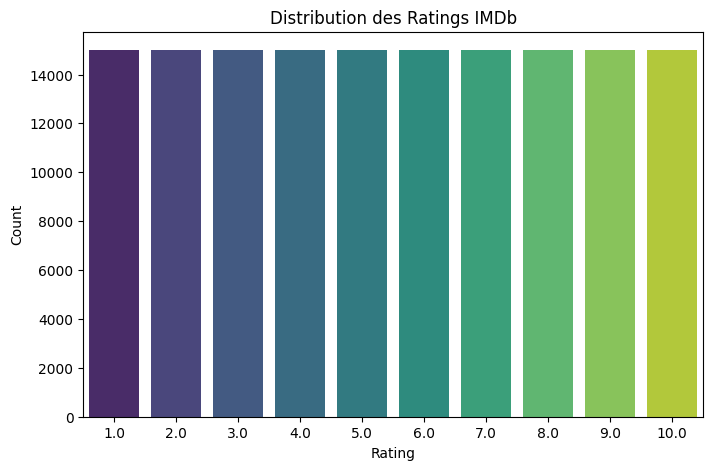

Ratings
5.0     15000
6.0     15000
9.0     15000
8.0     15000
7.0     14999
4.0     14999
10.0    14999
2.0     14998
3.0     14996
1.0     14984
Name: count, dtype: int64


In [14]:
#Checking for Class Imbalance
plt.figure(figsize=(8,5))
sns.countplot(x='Ratings', data=df, palette='viridis')
plt.title('Distribution des Ratings IMDb')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()
print(df['Ratings'].value_counts())

(np.float64(-0.5), np.float64(1499.5), np.float64(799.5), np.float64(-0.5))

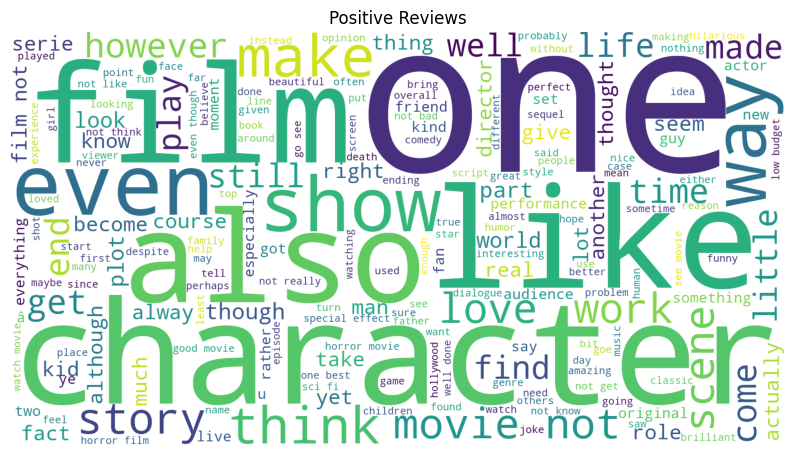

In [15]:
sentences=df['Reviews_clean']
pos=' '.join(map(str,sentences[df['Ratings']>=7]))
neg=' '.join(map(str,sentences[df['Ratings']<=4]))

pos_wordcloud = WordCloud(width = 1500, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 15).generate(pos)

plt.figure(figsize=(10,10))
plt.imshow(pos_wordcloud)
plt.title('Positive Reviews')
plt.axis('off')

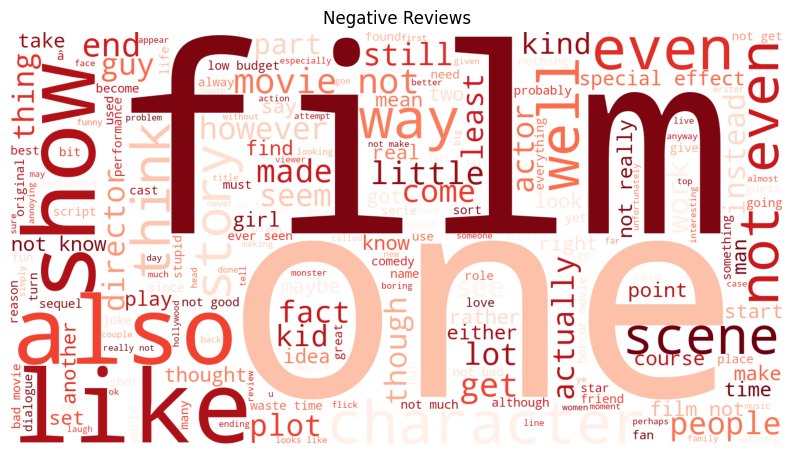

In [16]:
neg_wordcloud = WordCloud(width = 1500, height = 800,
                background_color ='white',
                stopwords = stop_words,
                colormap='Reds',
                min_font_size = 15).generate(neg)

plt.figure(figsize=(10,10))
plt.imshow(neg_wordcloud)
plt.title('Negative Reviews')
plt.axis('off')
plt.show()


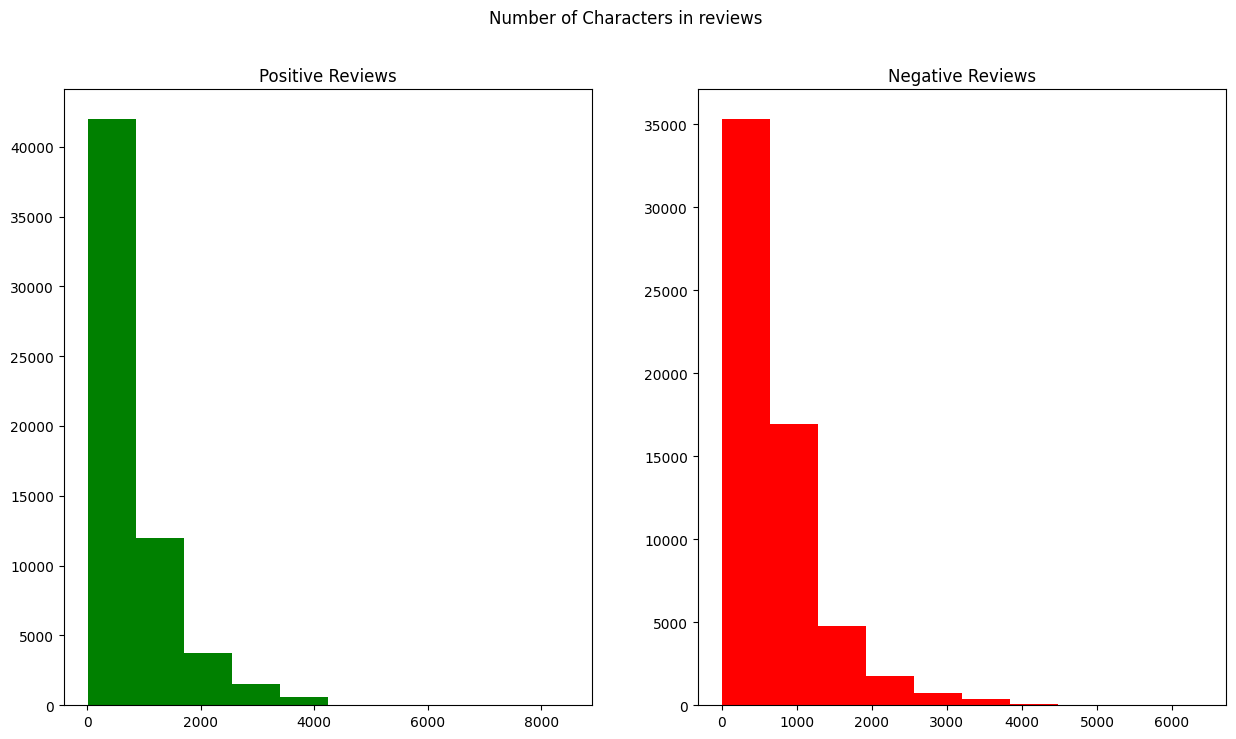

In [17]:
#Visulaization of number of charactor in reviews
figure,(pos_ax,neg_ax)=plt.subplots(1,2,figsize=(15,8))
len_pos_review=df[df['Ratings']>=7]['Reviews_clean'].str.len()
pos_ax.hist(len_pos_review,color='green')
pos_ax.set_title('Positive Reviews')
len_neg_review=df[df['Ratings']<=4]['Reviews_clean'].str.len()
neg_ax.hist(len_neg_review,color='red')
neg_ax.set_title('Negative Reviews')
figure.suptitle('Number of Characters in reviews')
plt.show()

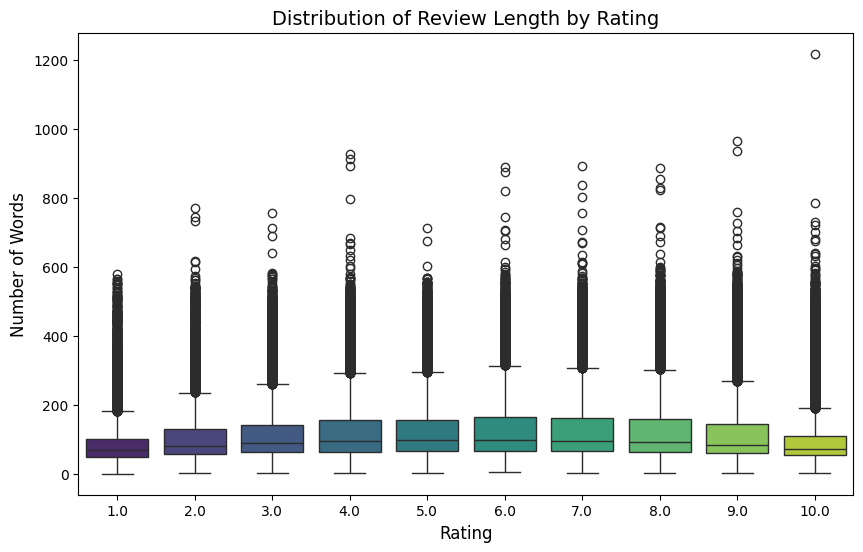

In [18]:
# Boxplot: Review length (in words) vs Rating

plt.figure(figsize=(10,6))
sns.boxplot(
    x='Ratings',
    y=df['Reviews_clean'].apply(lambda x: len(str(x).split())),
    data=df,
    palette='viridis'
)

plt.title('Distribution of Review Length by Rating', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Number of Words', fontsize=12)

plt.show()


Text(0.5, 0.98, 'Average word length in Reviews')

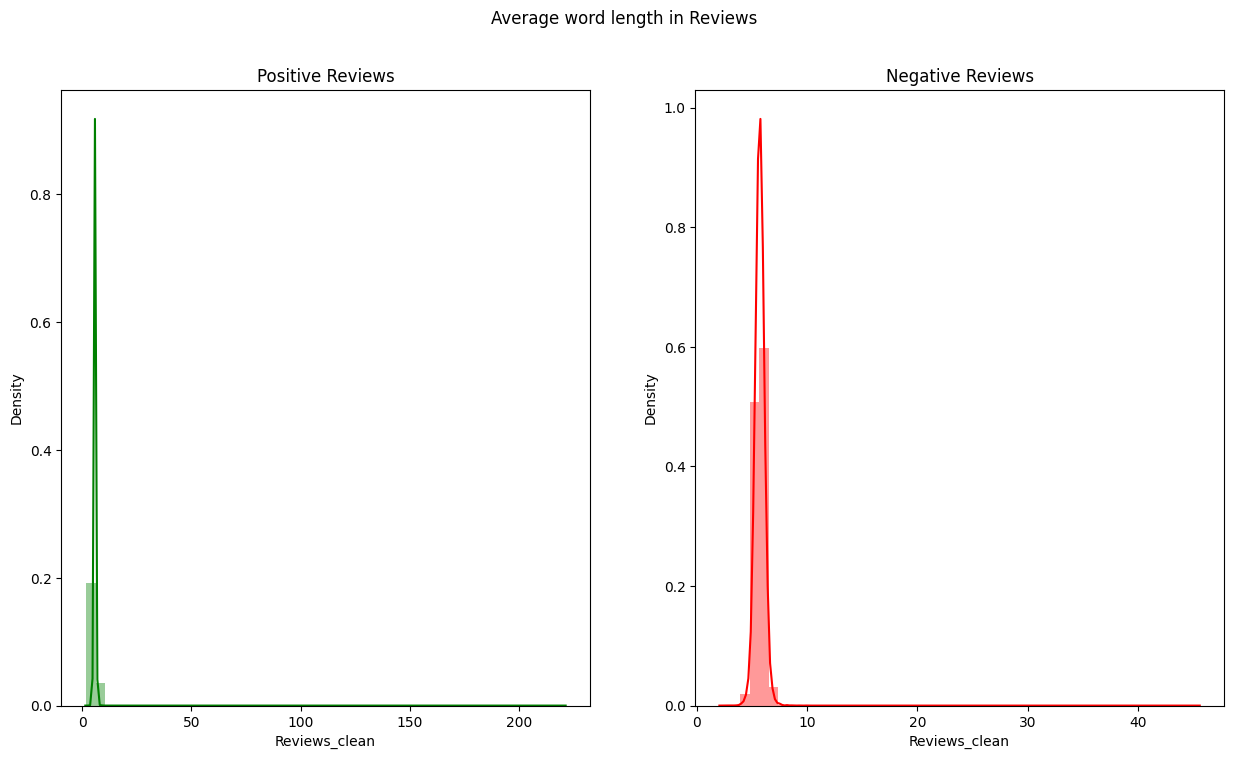

In [19]:
#Visulaize average of words in reviews

# Create a figure with two subplots (side by side)
figure,(pos_ax,neg_ax)=plt.subplots(1,2,figsize=(15,8))

# Positive reviews: Select reviews with Rating >= 7
# Split each review into words, then calculate the length of each word
pos_word=df[df['Ratings']>=7]['Reviews_clean'].str.split().apply(lambda x : [len(i) for i in x])

# Compute the average word length per review and plot the distribution (green)
sns.distplot(pos_word.map(lambda x: np.mean(x)),ax=pos_ax,color='green')
pos_ax.set_title('Positive Reviews')

# Negative Reviews: select reviews with Rating <= 4
# Split each review into words, then calculate the length of each word
neg_word=df[df['Ratings']<=4]['Reviews_clean'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(neg_word.map(lambda x: np.mean(x)),ax=neg_ax,color='red')
neg_ax.set_title('Negative Reviews')
figure.suptitle('Average word length in Reviews')

In [20]:
#Extract most frequent n-grams
def get_top_text_ngrams(corpus, n, g):

    # Initialize a CountVectorizer for the given n-gram size
    # It converts the corpus into a bag-of-words matrix counting how often each n-gram appears
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)

    # Transform the text data into a sparse matrix of word counts
    bag_of_words = vec.transform(corpus)

    # Sum all word occurrences across all documents (axis=0 = column-wise)
    sum_words = bag_of_words.sum(axis=0)

    # Create a list of tuples (word, frequency)
    # vec.vocabulary_ is a dictionary {word: index}
    # sum_words[0, idx] gives the total frequency of that word/n-gram
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    # Sort words by frequency in descending order
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    # Return the top 'n' most frequent n-grams
    return words_freq[:n]

In [21]:
most_common_uni = get_top_text_ngrams(df.Reviews_clean[df['Ratings']>=7],20,1)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Words in Positive Reviews', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [22]:
most_common_uni = get_top_text_ngrams(df.Reviews_clean[df['Ratings']>=7],20,3)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon trigram in Positive Reviews', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [23]:
most_common_uni = get_top_text_ngrams(df.Reviews_clean[df['Ratings']<=4],20,2)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon bigram in Negative Reviews', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [24]:
#Display reviews with high ratings (≥ 9) that still contain the phrase "bad review".
pd.options.display.max_colwidth = 1000
df[["Reviews","Ratings","Movies"]][(df['Ratings']>=9)&(df['Reviews'].str.contains("bad review"))].head(10)

,Reviews,Ratings,Movies
120211,"This movie was a blast for my little guys, they loved every minute of it, I have read all of the bad reviews, and could not disagree more. This movie, is pure and good. There is just enough action to keep the kids interested, and not so much that you leave the theater with them bouncing off the walls either. It is funny with jokes that everyone can appreciate. I think people have gotten used to so much violence and adult content in our kids movies that they are disappointed when it is missing, like the movie wasn't entertaining enough for the parents. Well, NEWS FLASH.....It's a kids movie, and a perfect one at that. Kids need these kinds of movies, not Spongebob and the like which are more to entertain the parents.",9.0,Doogal
120238,"I am a huge horror buff and prefer pieces that delve into the characters psychological issues. This film was awesome on so many levels, the acting and writing were fantastic and creepy and I was afraid or and empathetic with the murderer the whole time. What an interesting study on the line between sick and a danger to others, and the line between being a mean girl and being psychotic. Set in a great location, a house full of creepy art, in the winter in Conneticut and with amazing performances from many of my favorite actresses. It actually shocks me that others have given this such a bad review, I loved this movie, I guess it goes to show you everyone will have a different opinion but I say don't miss this film!",9.0,#Horror
120239,"No idea why there are so many bad reviews here? I loved it; I thought it was a very advanced thoughtful film. The graphic were #killer. The comparison of video game culture and young girl culture was spot on. This film makes connections that I've never seen on the big screen but, do see in every day life.The casting was spot on, Hello 12 year-old girls are supposed to be a little annoying. I do wish that more directors would take color into more consideration the way this film does. T The highly stylized sets make the murder scenes more believable because everything is so unbelievable. How can you live in 2016 and not ""get""a film about social media and accelerationism. #duh Someone explain this to me.",9.0,#Horror
120273,"What do you get when you cross Love Story with Star Wars with Blade Runner with Back to the Future with MTV? Love Story 2050, that's what. What a fun movie for the entire family. This fantasy of epic proportions is much, much better than AI, a similar sci-fi classic. The thrills are non-stop in this blockbuster, from its lead off car chase to bike racing stunts to the vantage point of a moving roller coaster to speeding hover-craft--you will be on the edge of your seat from beginning to end. The version I saw was only partially in English and I still was glued to the screen. I can't wait to see a version with subtitles. The mega budget special effects are out of this world and highly convincing. The future vision of XBox was hilarious. Those who are complaining about how long this movie is simply don't understand Bollywood. The three hours went by quickly; it seemed to be only an hour. There could have been a better twist with the Darth Vader character. For example, I suspected tha...",9.0,Love Story 2050
120334,"I don't understand the negative reviews for this movie.This deserve a 10 stars.Something is definitely wrong with people when they do not care for a positive message in a movie.This movie was beyond great,had a touch of everything.It shows what can happen when a person's influence can change lives.These young boys had no hope,they could not see a promising future.The streets are what they knew,and of course,some of you can't relate, but if you are a fair person,then you will try to understand it from that viewpoint.I was not raised in a bad neighborhood,nor the streets, and i still totally get this movie.Life is about sacrifices and there were many a lessons in this movie that are based on real life for s

In [25]:
# Extract and visualize the most frequent trigrams (three-word phrases) in NEGATIVE reviews (Ratings ≤ 4)

# Extract the top 50 trigrams (3-word sequences) from reviews rated ≤ 4 (negative reviews)
# get_top_text_ngrams() returns a list of tuples (trigram, frequency)
most_common_uni = get_top_text_ngrams(df.Reviews_clean[df['Ratings']<=4],50,3)

# Convert the list of tuples into a dictionary for easier DataFrame creation
most_common_uni = dict(most_common_uni)

# Create an empty DataFrame with two columns: one for the trigram, one for its frequency count
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])

# Fill the DataFrame with data: keys become trigrams, values become counts
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon trigram in Negative Reviews', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

**PHASE 2: Feature Engineering and Feature Selection**

**Feature Engineering**

In [26]:
#Mapping rating data to Binary label 1 (+ve) if rating >=7 and 0 (-ve) if rating <=4 and 2 (neutral) if rating = 5 or 6
df['Label'] = df['Ratings'].apply(lambda x: '1' if x >= 7 else ('0' if x<=4 else '2'))
#Removing
df=df[df.Label<'2']
data=df[['Reviews_clean','Label']]
print(data['Label'].value_counts())

Label
1    59998
0    59977
Name: count, dtype: int64


In [27]:
#Importing dependencies for feature engineering
import sys
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from prettytable import PrettyTable
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

**Lemmatization**

In [28]:
# lemmatization of word
#Cette classe Tokenize (sépare en mots), Lemmatize (ramène à la forme de base)
class LemmaTokenizer(object):
    def __init__(self):
        self.wordnetlemma = WordNetLemmatizer()
    def __call__(self, reviews):
        return [self.wordnetlemma.lemmatize(word) for word in word_tokenize(reviews)]

**Vectoization with Count Vectorizer and TDIDF Vectorizer with Unigram**

In [29]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\guesm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\guesm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\guesm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\guesm\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [30]:
train,test=train_test_split(data,test_size=.3,random_state=42, shuffle=True) #train 70%
countvect = CountVectorizer(analyzer = "word", tokenizer = LemmaTokenizer(), ngram_range=(1,1), min_df=10,max_features=500) #min_df=10: ignore les mots qui apparaissent dans moins de 10 documents
tfidfvect = TfidfVectorizer(analyzer = "word", tokenizer = LemmaTokenizer(), ngram_range=(1,1),min_df=10,max_features=500)
x_train_count = countvect.fit_transform(train['Reviews_clean']).toarray()
x_test_count = countvect.transform(test['Reviews_clean']).toarray()
x_train_tfidf = tfidfvect.fit_transform(train['Reviews_clean']).toarray()
x_test_tfidf = tfidfvect.transform(test['Reviews_clean']).toarray()
y_train = train['Label']
y_test = test['Label']

**Feature Importance with Logistic Regression and Count Vectorizer with unigram**

In [31]:
from prettytable import PrettyTable
from sklearn.linear_model import LogisticRegression

lgr = LogisticRegression()
lgr.fit(x_train_count, y_train)
print("Accuracy:", lgr.score(x_test_count, y_test))

i = 0
importantfeature = PrettyTable(["Feature", "Score"])

for feature, importance in zip(countvect.get_feature_names_out(), lgr.coef_[0]):
    if i <= 200:
        importantfeature.add_row([feature, importance])
        i += 1

print(importantfeature)


Accuracy: 0.8377462284333065
+----------------+------------------------+
|    Feature     |         Score          |
+----------------+------------------------+
|      able      |  0.09715499518048029   |
|   absolutely   |  0.026427368799922368  |
|      act       |  -0.10932633313367866  |
|     acting     |  -0.15198198765718587  |
|     action     |   0.2739941414189029   |
|     actor      |  -0.13587078274526812  |
|    actress     |  -0.13714411232877907  |
|    actually    |  -0.0475427542076401   |
|      add       |  0.025722051529238593  |
|     adult      |   0.0166937856545137   |
|      age       |  0.08383310229901406   |
|     alien      |  -0.04865849796886443  |
|     almost     |  -0.02577064461081972  |
|     alone      |  0.047440879048920505  |
|     along      |  0.10338834953463195   |
|    already     |  -0.2347077720216736   |
|      also      |   0.1175335912382532   |
|    although    |  0.20057478895547592   |
|     always     |  0.14732014688301717   |
|  

Feature Importance with TFIDF vectorizer and Logistic Regression with Unigram

In [32]:
from prettytable import PrettyTable
from sklearn.linear_model import LogisticRegression
import numpy as np

# Entraînement
lgr = LogisticRegression(max_iter=1000)
lgr.fit(x_train_tfidf, y_train)

# Accuracy
print("Accuracy (TF-IDF):", lgr.score(x_test_tfidf, y_test))

importantfeature = PrettyTable(["Feature", "Score"])
for i, (feature, importance) in enumerate(
        zip(tfidfvect.get_feature_names_out(), lgr.coef_[0])):
    if i <= 100:
        importantfeature.add_row([feature, float(importance)])
print(importantfeature)

# Top mots les plus influents (triés)
feature_names = tfidfvect.get_feature_names_out()
coefs = lgr.coef_[0]

# indices triés du plus grand au plus petit
order = np.argsort(coefs)

print("\nTop 10 mots POSITIFS (coefs élevés):")
for idx in order[-10:][::-1]:
    print(f"{feature_names[idx]:20s} {coefs[idx]: .4f}")

print("\nTop 10 mots NÉGATIFS (coefs faibles):")
for idx in order[:10]:
    print(f"{feature_names[idx]:20s} {coefs[idx]: .4f}")

Accuracy (TF-IDF): 0.8390242547161948
+----------------+-------------------------+
|    Feature     |          Score          |
+----------------+-------------------------+
|      able      |   0.46724685386892983   |
|   absolutely   |    0.3220158797516174   |
|      act       |   -0.9266772525539582   |
|     acting     |    -1.406482653906164   |
|     action     |    2.588521516783889    |
|     actor      |   -1.3953019944847032   |
|    actress     |   -0.7315497871080672   |
|    actually    |   -0.4316250600121617   |
|      add       |   0.05468454223458947   |
|     adult      |    0.5315211624197451   |
|      age       |    0.8061077765916144   |
|     alien      |   -0.1964334259083321   |
|     almost     |   -0.31373289781057306  |
|     alone      |   0.14840777713066303   |
|     along      |    0.8241104977416386   |
|    already     |    -1.121518177871605   |
|      also      |    1.4123083302698916   |
|    although    |    1.1763817878209972   |
|     always     

**Vectorization with Count Vectorizer and TDIDF Vectorizer with Bigram**

In [33]:
train,test=train_test_split(data,test_size=.3,random_state=42, shuffle=True)
countvect = CountVectorizer(analyzer = "word", tokenizer = LemmaTokenizer(), ngram_range=(2,2), min_df=10,max_features=500)
tfidfvect = TfidfVectorizer(analyzer = "word", tokenizer = LemmaTokenizer(), ngram_range=(2,2),min_df=10,max_features=500)
x_train_count = countvect.fit_transform(train['Reviews_clean']).toarray()
x_test_count = countvect.transform(test['Reviews_clean']).toarray()
x_train_tfidf = tfidfvect.fit_transform(train['Reviews_clean']).toarray()
x_test_tfidf = tfidfvect.transform(test['Reviews_clean']).toarray()
y_train = train['Label']
y_test = test['Label']

**Feature Importance with Logistic Regression and TFIDF Vectorizer with Bigram**

In [34]:
lgr.fit(x_train_tfidf, y_train)
lgr.score(x_test_tfidf, y_test)
lgr.coef_[0]
features = tfidfvect.get_feature_names_out()

importantfeature = PrettyTable(["Feature", "Score"])

for i, (feature, importance) in enumerate(zip(features, lgr.coef_[0])):
    if i < 50:  # afficher seulement les 50 premières pour éviter un affichage trop long
        importantfeature.add_row([feature, importance])

print(importantfeature)


+-----------------------+-----------------------+
|        Feature        |         Score         |
+-----------------------+-----------------------+
|       acting bad      |  -2.9665732200044665  |
|      acting good      |   1.444484247795561   |
|       acting not      |   -1.155875157823196  |
|      action film      |   1.0535778711578112  |
|      action movie     |   0.8842385342266924  |
|     action packed     |   2.9070445431536847  |
|      action scene     |   0.5361876537485838  |
|    action sequence    |   0.4860077149439834  |
|     actor actress     |  -0.4316953645347633  |
|       actor not       |   -0.836836683994538  |
|         ai not        |  0.13357294442675938  |
|      almost every     | -0.022937180404139862 |
|       along way       |   0.9659413535495174  |
|        also not       |  -0.2728951133195951  |
|      although not     |   1.0301009259216547  |
|     anything else     |  -0.6902203905493443  |
|        b movie        |   -0.503002338980242  |


**Feature Selection with Chi squared**

In [35]:
from sklearn.feature_selection import chi2
import numpy as np

# Calcul des scores Chi²
chi2_scores, p_values = chi2(x_train_tfidf, y_train)

# Associer chaque mot à son score
feature_names = np.array(tfidfvect.get_feature_names_out())
sorted_features = feature_names[np.argsort(chi2_scores)]

# Afficher les 20 plus discriminants
print("Top 20 features les plus discriminantes selon Chi² :")
print(sorted_features[-20:])

Top 20 features les plus discriminantes selon Chi² :
['best movie' 'pleasantly surprised' 'even worse' 'must see' 'not funny'
 'highly recommend' 'well done' 'really enjoyed' 'really bad' 'great job'
 'bad movie' 'not worth' 'look like' 'bad acting' 'not waste' 'one worst'
 'worst movie' 'one best' 'not even' 'waste time']


**Vectorization with TDIDF Vectorizer with unigram, bigram and trigram then feature selection**

In [36]:
train,test=train_test_split(data,test_size=.3,random_state=42, shuffle=True)
tfidfvect = TfidfVectorizer(analyzer = "word", tokenizer = LemmaTokenizer(), ngram_range=(1,3),min_df=10,max_features=10000)
x_train_tfidf = tfidfvect.fit_transform(train['Reviews_clean']).toarray()
x_test_tfidf = tfidfvect.transform(test['Reviews_clean']).toarray()

y_train = train['Label']
y_test = test['Label']

In [37]:
from sklearn.feature_selection import chi2
import numpy as np

# Nombre de mots à afficher par catégorie
TOP_N = 10
Number = 1

for category in train['Label'].unique():
    # Calcul du Chi² pour chaque feature
    chi2_scores, p_values = chi2(x_train_tfidf, train['Label'] == category)

    # Trie des indices selon le score
    indices = np.argsort(chi2_scores)
    feature_names = np.array(tfidfvect.get_feature_names_out())[indices]

    # Séparation des n-grams
    unigrams = [x for x in feature_names if len(x.split(' ')) == 1]
    bigrams  = [x for x in feature_names if len(x.split(' ')) == 2]
    trigrams = [x for x in feature_names if len(x.split(' ')) == 3]

    print(f"\n{Number}. Classe = {category}")
    print(f"\tTop {TOP_N} Unigrams : {', '.join(unigrams[-TOP_N:])}")
    print(f"\tTop {TOP_N} Bigrams  : {', '.join(bigrams[-TOP_N:]) if bigrams else '—'}")
    print(f"\tTop {TOP_N} Trigrams : {', '.join(trigrams[-TOP_N:]) if trigrams else '—'}")

    Number += 1


1. Classe = 1
	Top 10 Unigrams : worse, boring, poor, loved, awful, terrible, waste, bad, great, worst
	Top 10 Bigrams  : really enjoyed, bad movie, not worth, bad acting, one worst, one best, not waste, worst movie, not even, waste time
	Top 10 Trigrams : worst movie seen, complete waste time, one best movie, worst film ever, really enjoyed movie, bad acting bad, waste time money, one worst movie, not waste time, worst movie ever

2. Classe = 0
	Top 10 Unigrams : worse, boring, poor, loved, awful, terrible, waste, bad, great, worst
	Top 10 Bigrams  : really enjoyed, bad movie, not worth, bad acting, one worst, one best, not waste, worst movie, not even, waste time
	Top 10 Trigrams : worst movie seen, complete waste time, one best movie, worst film ever, really enjoyed movie, bad acting bad, waste time money, one worst movie, not waste time, worst movie ever


In [38]:
import sys
import numpy as np
import scipy as sp
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

**Logistic Regression Model**

In [39]:
model_1 = LogisticRegression(max_iter=300)
model_1.fit(x_train_tfidf,y_train)

LogisticRegression(max_iter=300)

In [40]:
y_pred = model_1.predict(x_test_tfidf)

In [41]:
y_pred_train = model_1.predict(x_train_tfidf)
y_score_train = model_1.predict_proba(x_train_tfidf)[:, 1]

print("Logistic Regression - TRAIN SET")
print("Precision:", precision_score(y_train, y_pred_train, average='macro'))
print("F1 Score :", f1_score(y_train, y_pred_train, average='weighted'))
print("ROC-AUC  :", roc_auc_score(y_train, y_score_train))

y_pred_test = model_1.predict(x_test_tfidf)
y_score_test = model_1.predict_proba(x_test_tfidf)[:, 1]

print("\n Logistic Regression - TEST SET")
print("Precision:", precision_score(y_test, y_pred_test, average='macro'))
print("F1 Score :", f1_score(y_test, y_pred_test, average='weighted'))
print("ROC-AUC  :", roc_auc_score(y_test, y_score_test))


Logistic Regression - TRAIN SET
Precision: 0.9175361526336439
F1 Score : 0.9175293457683588
ROC-AUC  : 0.9728933932508412

 Logistic Regression - TEST SET
Precision: 0.8976415137915992
F1 Score : 0.8976480267321245
ROC-AUC  : 0.9615953748374028


**Linear SVM**

In [42]:
from sklearn.svm import LinearSVC

model_2 = LinearSVC(C=1.0)
model_2.fit(x_train_tfidf, y_train)

y_pred_svm = model_2.predict(x_test_tfidf)

print(" Linear SVM ")
print("Accuracy :", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm, average='macro'))
print("Recall   :", recall_score(y_test, y_pred_svm, average='macro'))
print("F1-score :", f1_score(y_test, y_pred_svm, average='weighted'))
print(classification_report(y_test, y_pred_svm, digits=3))

 Linear SVM 
Accuracy : 0.8923957436168144
Precision: 0.8923893412671623
Recall   : 0.8923914955151407
F1-score : 0.8923958913053359
              precision    recall  f1-score   support

           0      0.893     0.893     0.893     18127
           1      0.891     0.892     0.892     17866

    accuracy                          0.892     35993
   macro avg      0.892     0.892     0.892     35993
weighted avg      0.892     0.892     0.892     35993



**Decision Tree Classifier**

In [43]:
model_3 = Pipeline(steps=[("classifier", DecisionTreeClassifier())])
model_3.fit(x_train_tfidf, y_train)

Pipeline(steps=[('classifier', DecisionTreeClassifier())])

In [44]:
model_3.fit(x_train_tfidf,y_train)

Pipeline(steps=[('classifier', DecisionTreeClassifier())])

In [45]:
y_pred_3 = model_3.predict(x_test_tfidf)

print("=== Decision Tree Classifier ===")
print("Accuracy :", accuracy_score(y_test, y_pred_3))
print("Precision:", precision_score(y_test, y_pred_3, average='macro'))
print("Recall   :", recall_score(y_test, y_pred_3, average='macro'))
print("F1-score :", f1_score(y_test, y_pred_3, average='weighted'))
print(classification_report(y_test, y_pred_3, digits=3))

=== Decision Tree Classifier ===
Accuracy : 0.7208068235490234
Precision: 0.7207965522630733
Recall   : 0.7208052380355968
F1-score : 0.7208095692359354
              precision    recall  f1-score   support

           0      0.724     0.721     0.722     18127
           1      0.718     0.721     0.719     17866

    accuracy                          0.721     35993
   macro avg      0.721     0.721     0.721     35993
weighted avg      0.721     0.721     0.721     35993



In [46]:
y_train_pred_3 = model_3.predict(x_train_tfidf)
print("Train Accuracy:", accuracy_score(y_train, y_train_pred_3))
print("Test Accuracy :", accuracy_score(y_test, y_pred_3))

Train Accuracy: 0.9999285561191684
Test Accuracy : 0.7208068235490234


Pour confirmer que réduire la profondeur diminue l’overfit:

In [47]:
for depth in [5, 8, 11, 14, 20]:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(x_train_tfidf, y_train)
    y_pred = clf.predict(x_test_tfidf)
    print(f"max_depth={depth:<4}  acc={accuracy_score(y_test,y_pred):.3f}  f1w={f1_score(y_test,y_pred,average='weighted'):.3f}")


max_depth=5     acc=0.673  f1w=0.658
max_depth=8     acc=0.712  f1w=0.708
max_depth=11    acc=0.723  f1w=0.720
max_depth=14    acc=0.723  f1w=0.720
max_depth=20    acc=0.737  f1w=0.737


Model 3: Decision Tree Classifier Regularized with max_depth=11 to Reduce Overfitting


In [48]:
model_3 = Pipeline(
    steps=[
        ("classifier", DecisionTreeClassifier( criterion='gini', max_depth=11, min_samples_split=2, min_samples_leaf=1)),
    ]
)

In [49]:
model_3.fit(x_train_tfidf,y_train)

Pipeline(steps=[('classifier', DecisionTreeClassifier(max_depth=11))])

In [50]:
y_pred_3 = model_3.predict(x_test_tfidf)

print("=== Decision Tree Classifier (model_3) ===")
print("Accuracy :", accuracy_score(y_test, y_pred_3))
print("Precision:", precision_score(y_test, y_pred_3, average='macro'))
print("Recall   :", recall_score(y_test, y_pred_3, average='macro'))
print("F1-score :", f1_score(y_test, y_pred_3, average='weighted'))
print("ROC-AUC  :", roc_auc_score(y_test, model_3.predict_proba(x_test_tfidf)[:,1]))
print(classification_report(y_test, y_pred_3, digits=3))

=== Decision Tree Classifier (model_3) ===
Accuracy : 0.7231961770344234
Precision: 0.7342852166340785
Recall   : 0.723969197922063
F1-score : 0.7201176652039997
ROC-AUC  : 0.7804076538328268
              precision    recall  f1-score   support

           0      0.787     0.617     0.692     18127
           1      0.681     0.831     0.749     17866

    accuracy                          0.723     35993
   macro avg      0.734     0.724     0.720     35993
weighted avg      0.735     0.723     0.720     35993



In [51]:
print("=== Decision Tree Classifier (model_3) ===\n")

# Évaluation sur le TRAIN
y_train_pred_3 = model_3.predict(x_train_tfidf)
train_acc = accuracy_score(y_train, y_train_pred_3)
train_prec = precision_score(y_train, y_train_pred_3, average='macro')
train_rec = recall_score(y_train, y_train_pred_3, average='macro')
train_f1 = f1_score(y_train, y_train_pred_3, average='weighted')
train_auc = roc_auc_score(y_train, model_3.predict_proba(x_train_tfidf)[:,1])

print("Train set performance:")
print(f"  Accuracy : {train_acc:.4f}")
print(f"  Precision: {train_prec:.4f}")
print(f"  Recall   : {train_rec:.4f}")
print(f"  F1-score : {train_f1:.4f}")
print(f"  ROC-AUC  : {train_auc:.4f}\n")

# Évaluation sur le TEST
y_test_pred_3 = model_3.predict(x_test_tfidf)
test_acc = accuracy_score(y_test, y_test_pred_3)
test_prec = precision_score(y_test, y_test_pred_3, average='macro')
test_rec = recall_score(y_test, y_test_pred_3, average='macro')
test_f1 = f1_score(y_test, y_test_pred_3, average='weighted')
test_auc = roc_auc_score(y_test, model_3.predict_proba(x_test_tfidf)[:,1])

print(" Test set performance:")
print(f"  Accuracy : {test_acc:.4f}")
print(f"  Precision: {test_prec:.4f}")
print(f"  Recall   : {test_rec:.4f}")
print(f"  F1-score : {test_f1:.4f}")
print(f"  ROC-AUC  : {test_auc:.4f}\n")

print("Detailed Classification Report (Test):")
print(classification_report(y_test, y_test_pred_3, digits=3))


=== Decision Tree Classifier (model_3) ===

Train set performance:
  Accuracy : 0.7491
  Precision: 0.7604
  Recall   : 0.7487
  F1-score : 0.7462
  ROC-AUC  : 0.8198

 Test set performance:
  Accuracy : 0.7232
  Precision: 0.7343
  Recall   : 0.7240
  F1-score : 0.7201
  ROC-AUC  : 0.7804

Detailed Classification Report (Test):
              precision    recall  f1-score   support

           0      0.787     0.617     0.692     18127
           1      0.681     0.831     0.749     17866

    accuracy                          0.723     35993
   macro avg      0.734     0.724     0.720     35993
weighted avg      0.735     0.723     0.720     35993



Random Forest

In [52]:
model_4 = Pipeline(
    steps=[
    ("classifier", RandomForestClassifier(random_state=42, n_jobs=-1))]
)

In [53]:
model_4.fit(x_train_tfidf,y_train)

Pipeline(steps=[('classifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

In [54]:
# Eval TRAIN
y_train_pred_4 = model_4.predict(x_train_tfidf)
y_train_proba_4 = model_4.predict_proba(x_train_tfidf)[:,1]
print("=== Random Forest (model_4) — TRAIN ===")
print("Accuracy :", accuracy_score(y_train, y_train_pred_4))
print("Precision:", precision_score(y_train, y_train_pred_4, average='macro'))
print("Recall   :", recall_score(y_train, y_train_pred_4, average='macro'))
print("F1-score :", f1_score(y_train, y_train_pred_4, average='weighted'))
print("ROC-AUC  :", roc_auc_score(y_train, y_train_proba_4))

# Eval TEST
y_test_pred_4 = model_4.predict(x_test_tfidf)
y_test_proba_4 = model_4.predict_proba(x_test_tfidf)[:,1]
print("\n=== Random Forest (model_4) — TEST ===")
print("Accuracy :", accuracy_score(y_test, y_test_pred_4))
print("Precision:", precision_score(y_test, y_test_pred_4, average='macro'))
print("Recall   :", recall_score(y_test, y_test_pred_4, average='macro'))
print("F1-score :", f1_score(y_test, y_test_pred_4, average='weighted'))
print("ROC-AUC  :", roc_auc_score(y_test, y_test_proba_4))
print(classification_report(y_test, y_test_pred_4, digits=3))

=== Random Forest (model_4) — TRAIN ===
Accuracy : 0.9999285561191684
Precision: 0.9999283256880733
Recall   : 0.9999287952150384
F1-score : 0.9999285561359432
ROC-AUC  : 0.9999999897914287

=== Random Forest (model_4) — TEST ===
Accuracy : 0.8572222376573223
Precision: 0.8572273290548194
Recall   : 0.8572455556940872
F1-score : 0.857224058798335
ROC-AUC  : 0.9309837683227715
              precision    recall  f1-score   support

           0      0.861     0.854     0.858     18127
           1      0.853     0.860     0.857     17866

    accuracy                          0.857     35993
   macro avg      0.857     0.857     0.857     35993
weighted avg      0.857     0.857     0.857     35993



Ada Boost Classifier

In [55]:
model_5 = Pipeline(
    steps=[
        ("classifier", AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=4),
            n_estimators=100,
            learning_rate=0.8
        )),
    ]
)

In [56]:
model_5.fit(x_train_tfidf,y_train)

Pipeline(steps=[('classifier',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4),
                                    learning_rate=0.8, n_estimators=100))])

In [57]:
print("=== AdaBoost Classifier (model_5) ===\n")

# --- Train ---
y_train_pred_5 = model_5.predict(x_train_tfidf)
y_train_proba_5 = model_5.predict_proba(x_train_tfidf)[:, 1]

train_precision = precision_score(y_train, y_train_pred_5, average='micro')
train_auc = roc_auc_score(y_train, y_train_proba_5)
train_f1 = f1_score(y_train, y_train_pred_5, average="weighted")

print(" Train set performance:")
print("Accuracy :", accuracy_score(y_train, y_train_pred_5))
print(f"  Precision : {train_precision}")
print(f"  F1-score  : {train_f1}")
print(f"  ROC-AUC   : {train_auc}\n")

# --- Test ---
y_test_pred_5 = model_5.predict(x_test_tfidf)
y_test_proba_5 = model_5.predict_proba(x_test_tfidf)[:, 1]

test_precision = precision_score(y_test, y_test_pred_5, average='micro')
test_auc = roc_auc_score(y_test, y_test_proba_5)
test_f1 = f1_score(y_test, y_test_pred_5, average="weighted")

print(" Test set performance:")
print(f"  Precision : {test_precision:.4f}")
print(f"  F1-score  : {test_f1:.4f}")
print(f"  ROC-AUC   : {test_auc:.4f}")

print("\nDetailed Classification Report (Test):")
print(classification_report(y_test, y_test_pred_5, digits=3))


=== AdaBoost Classifier (model_5) ===

 Train set performance:
Accuracy : 0.8496106308494678
  Precision : 0.8496106308494678
  F1-score  : 0.8496109216929385
  ROC-AUC   : 0.9286169796217634

 Test set performance:
  Precision : 0.8355
  F1-score  : 0.8355
  ROC-AUC   : 0.9169

Detailed Classification Report (Test):
              precision    recall  f1-score   support

           0      0.837     0.836     0.837     18127
           1      0.834     0.835     0.834     17866

    accuracy                          0.835     35993
   macro avg      0.835     0.835     0.835     35993
weighted avg      0.835     0.835     0.835     35993



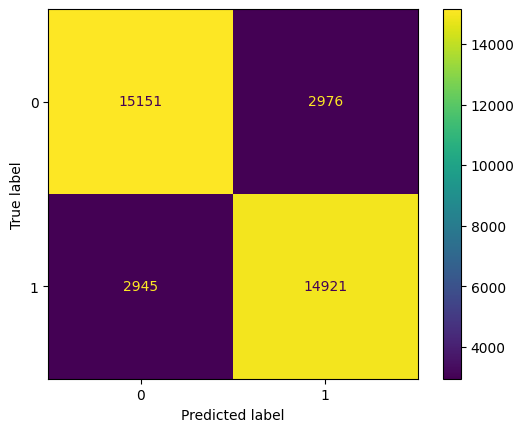

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, model_5.predict(x_test_tfidf))
ConfusionMatrixDisplay(cm).plot()

In [63]:
from sklearn import ensemble
from sklearn import metrics
from sklearn import model_selection

def hyperparamtune(classifier, param_grid,metric,verbose_value,cv):
    model=model_selection.GridSearchCV(
            estimator=classifier,
            param_grid=param_grid,
            scoring=metric,
            verbose=verbose_value,            
            cv=cv,
            n_jobs=2)

    model.fit(x_train_tfidf,y_train)
    print("Best Score %s" % {model.best_score_})
    print("Best hyperparameter set:")
    best_parameters = model.best_estimator_.get_params()
    for param_name in sorted(param_grid.keys()):
        print(f"\t{param_name}: {best_parameters[param_name]}")
    return model, best_parameters

In [64]:
%%time
param_gd={"penalty":["l2","l1"],
         "C":[0.01,0.1,1.0,10],
         "tol":[0.0001,0.001,0.01],
         "max_iter":[100,200]}
model_7, best_param = hyperparamtune(LogisticRegression(),param_gd,"accuracy",10,5)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Score {np.float64(0.8964421266893181)}
Best hyperparameter set:
	C: 1.0
	max_iter: 100
	penalty: l2
	tol: 0.0001
CPU times: total: 5min 30s
Wall time: 31min 12s


In [65]:
best_lr = model_7.best_estimator_

y_train_pred = best_lr.predict(x_train_tfidf)
y_train_proba = best_lr.predict_proba(x_train_tfidf)[:, 1]

y_test_pred = best_lr.predict(x_test_tfidf)
y_test_proba = best_lr.predict_proba(x_test_tfidf)[:, 1]

print("=== TRAINING SET PERFORMANCE ===")
print(f"Accuracy  : {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Precision : {precision_score(y_train, y_train_pred, average='weighted'):.4f}")
print(f"Recall    : {recall_score(y_train, y_train_pred, average='weighted'):.4f}")
print(f"F1-score  : {f1_score(y_train, y_train_pred, average='weighted'):.4f}")
print(f"ROC-AUC   : {roc_auc_score(y_train, y_train_proba):.4f}")
print("-" * 50)

print("=== TEST SET PERFORMANCE ===")
print(f"Accuracy  : {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision : {precision_score(y_test, y_test_pred, average='weighted'):.4f}")
print(f"Recall    : {recall_score(y_test, y_test_pred, average='weighted'):.4f}")
print(f"F1-score  : {f1_score(y_test, y_test_pred, average='weighted'):.4f}")
print(f"ROC-AUC   : {roc_auc_score(y_test, y_test_proba):.4f}")

# ---- Detailed report on test ----
print("\nDetailed classification report (test):")
print(classification_report(y_test, y_test_pred))

=== TRAINING SET PERFORMANCE ===
Accuracy  : 0.9175
Precision : 0.9175
Recall    : 0.9175
F1-score  : 0.9175
ROC-AUC   : 0.9729
--------------------------------------------------
=== TEST SET PERFORMANCE ===
Accuracy  : 0.8976
Precision : 0.8977
Recall    : 0.8976
F1-score  : 0.8976
ROC-AUC   : 0.9616

Detailed classification report (test):
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     18127
           1       0.89      0.90      0.90     17866

    accuracy                           0.90     35993
   macro avg       0.90      0.90      0.90     35993
weighted avg       0.90      0.90      0.90     35993



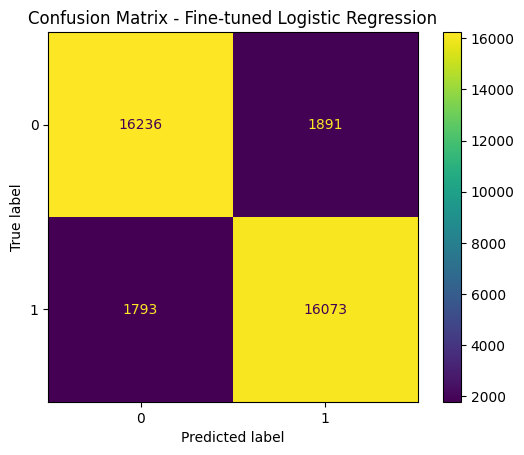

In [66]:
# ---- Confusion Matrix ----
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.title("Confusion Matrix - Fine-tuned Logistic Regression")
plt.show()

In [67]:
import joblib

# Save the whole GridSearchCV (includes cv_results_, best_params_, etc.)
joblib.dump(model_7, "logreg_gridsearch_model7.joblib")

# Save only the best estimator (plain LogisticRegression trained on TF-IDF matrices)
best_lr = model_7.best_estimator_
joblib.dump(best_lr, "logreg_best_estimator_model7.joblib")

print("Saved: logreg_gridsearch_model7.joblib, logreg_best_estimator_model7.joblib")


Saved: logreg_gridsearch_model7.joblib, logreg_best_estimator_model7.joblib


In [86]:
# Save the TF-IDF vectorizer used with model_7
joblib.dump(tfidfvect, "logreg_tfidf_vectorizer_model7.joblib")
print("Saved: logreg_tfidf_vectorizer_model7.joblib")

Saved: logreg_tfidf_vectorizer_model7.joblib


In [68]:
tok = LemmaTokenizer()

model_8 = Pipeline([
    ("tfidf", TfidfVectorizer(
        tokenizer=tok,
        ngram_range=(1, 3),      
        min_df=5,
        max_features=50000,
        dtype=np.float32
    )),
    ("clf", LogisticRegression(
        penalty="l2",
        C=1.0,
        tol=1e-4,
        max_iter=1000,
        solver="saga",        
        n_jobs=-1
    ))
])



=== TRAINING SET PERFORMANCE ===
Accuracy  : 0.9325
Precision : 0.9325
Recall    : 0.9325
F1-score  : 0.9325
ROC-AUC   : 0.9808
--------------------------------------------------
=== TEST SET PERFORMANCE ===
Accuracy  : 0.9022
Precision : 0.9022
Recall    : 0.9022
F1-score  : 0.9022
ROC-AUC   : 0.9639

Detailed classification report (test):
              precision    recall  f1-score   support

           0       0.91      0.90      0.90     18127
           1       0.90      0.90      0.90     17866

    accuracy                           0.90     35993
   macro avg       0.90      0.90      0.90     35993
weighted avg       0.90      0.90      0.90     35993



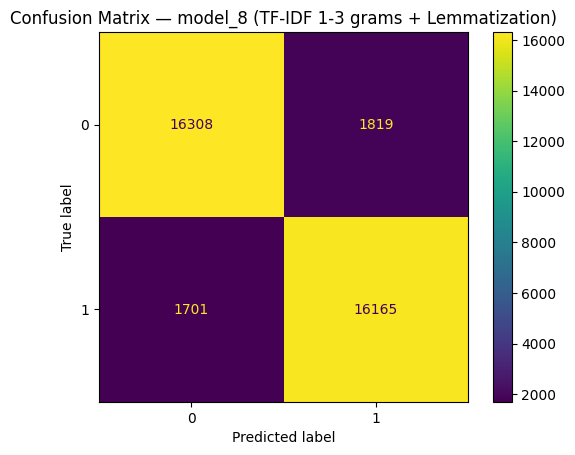

In [69]:
model_8.fit(train["Reviews_clean"], y_train)

# ---- TRAIN metrics ----
ytr_pred  = model_8.predict(train["Reviews_clean"])
ytr_proba = model_8.predict_proba(train["Reviews_clean"])[:, 1]

print("\n=== TRAINING SET PERFORMANCE ===")
print(f"Accuracy  : {accuracy_score(y_train, ytr_pred):.4f}")
print(f"Precision : {precision_score(y_train, ytr_pred, average='weighted'):.4f}")
print(f"Recall    : {recall_score(y_train, ytr_pred, average='weighted'):.4f}")
print(f"F1-score  : {f1_score(y_train, ytr_pred, average='weighted'):.4f}")
print(f"ROC-AUC   : {roc_auc_score(y_train, ytr_proba):.4f}")
print("-" * 50)

# ---- TEST metrics ----
yte_pred  = model_8.predict(test["Reviews_clean"])
yte_proba = model_8.predict_proba(test["Reviews_clean"])[:, 1]

print("=== TEST SET PERFORMANCE ===")
print(f"Accuracy  : {accuracy_score(y_test, yte_pred):.4f}")
print(f"Precision : {precision_score(y_test, yte_pred, average='weighted'):.4f}")
print(f"Recall    : {recall_score(y_test, yte_pred, average='weighted'):.4f}")
print(f"F1-score  : {f1_score(y_test, yte_pred, average='weighted'):.4f}")
print(f"ROC-AUC   : {roc_auc_score(y_test, yte_proba):.4f}")

print("\nDetailed classification report (test):")
print(classification_report(y_test, yte_pred))

ConfusionMatrixDisplay.from_predictions(y_test, yte_pred)
plt.title("Confusion Matrix — model_8 (TF-IDF 1-3 grams + Lemmatization)")
plt.show()


In [70]:
joblib.dump(model_8, "logreg_tfidf_lemma_pipeline_model8.joblib")
print("Saved: logreg_tfidf_lemma_pipeline_model8.joblib")

Saved: logreg_tfidf_lemma_pipeline_model8.joblib


Explainable AI (XAI) with SHAP for Logistic Regression

In [73]:
import shap
shap.initjs()

In [74]:
explainer = shap.Explainer(best_lr, x_train_tfidf, feature_names=tfidfvect.get_feature_names_out()) # Create a SHAP explainer for the tuned Logistic Regression model
shap_values = explainer(x_test_tfidf) # Compute SHAP values for the test set
# This calculates the contribution of feature to each individual prediction made by the model on the test data

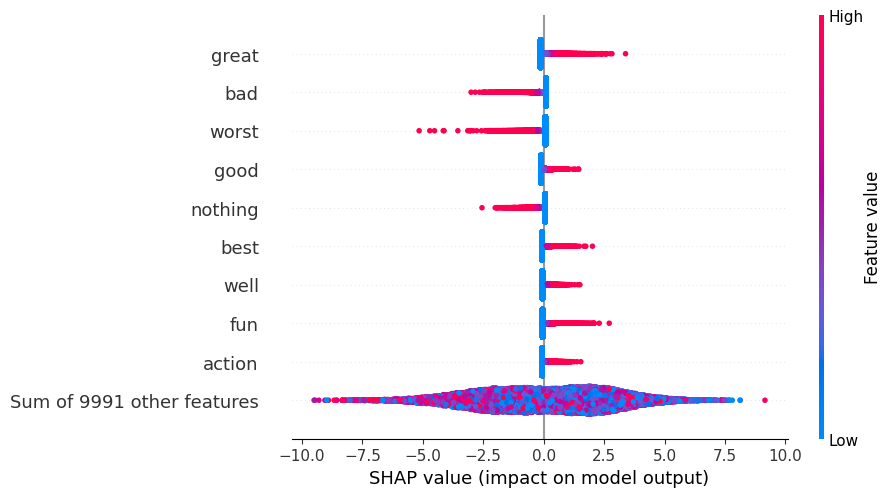

In [75]:
shap.plots.beeswarm(shap_values) # Visualize global feature importance with a Beeswarm plot

Local explanation for one review

In [81]:
idx = 1

# show prediction confidence and truth
y_test_proba = best_lr.predict_proba(x_test_tfidf)[:, 1]
y_test_pred  = best_lr.predict(x_test_tfidf)
print(test["Reviews_clean"].iloc[idx])
print(f"Predicted proba (class 1): {y_test_proba[idx]:.4f}")
print("Predicted label:", int(y_test_pred[idx]))
print("True label     :", int(y_test.iloc[idx]))  

# SHAP local explanation 
try:
    shap.plots.force(shap_values[idx])   
except Exception:
    shap.plots.waterfall(shap_values[idx], max_display=20)  


actually invited private screening movie turn left switzerland must say impressed performance actors new comers john bourke james yarborough chris bland mark coronado proved work together well feel film cast well first time director dominic jackson also surprised receive cool movie soundtrack screening overall feel film great potential really think one surprise success stories making prepare one crazy joyride
Predicted proba (class 1): 0.9635
Predicted label: 1
True label     : 1


In [83]:
from lime.lime_text import LimeTextExplainer

# model_8: the Pipeline
# test["Reviews_clean"]: the raw text column for the test set
explainer_lime = LimeTextExplainer(class_names=[0, 1])

idx = 1
text = test["Reviews_clean"].iloc[idx]

print("Pipeline predicted:", model_8.predict([text])[0],
      "with proba:", model_8.predict_proba([text])[0])

exp = explainer_lime.explain_instance(
    text_instance=text,
    classifier_fn=model_8.predict_proba, 
    num_features=15,
    top_labels=2
)

exp.show_in_notebook(text=True)


exp.as_list(label=1)   


Pipeline predicted: 1 with proba: [0.04501677 0.95498323]


[(np.str_('well'), 0.07246966683710276),
 (np.str_('bland'), -0.0693466485095533),
 (np.str_('great'), 0.06562958398660299),
 (np.str_('potential'), -0.05421859668046158),
 (np.str_('surprised'), 0.051944731338911365),
 (np.str_('screening'), 0.04455343794171555),
 (np.str_('impressed'), 0.03796651918905148),
 (np.str_('first'), 0.031073007911888606),
 (np.str_('performance'), 0.02949337081912507),
 (np.str_('surprise'), 0.027417966363417232),
 (np.str_('cool'), 0.025428863136949944),
 (np.str_('crazy'), 0.02326090914782615),
 (np.str_('think'), 0.021872394932988003),
 (np.str_('really'), -0.020742143928863175),
 (np.str_('left'), -0.01831871834758911)]

In [84]:
import joblib, os

if 'model_8' not in globals():
    path = "logreg_tfidf_lemma_pipeline_model8.joblib"
    assert os.path.exists(path), f"Model file not found: {path}"
    model_8 = joblib.load(path)

label_names = {0: "Negative", 1: "Positive"}